to be executed after

> `cd src`
 
> `python main.py`

In [1]:
import glob
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
from pathlib import Path
from numpy.random import seed
# import tensorflow as tf
from operator import itemgetter

cherrypicked_seed = 42

seed(cherrypicked_seed)
# tf.random.set_seed(cherrypicked_seed)
random.seed(cherrypicked_seed)
 

100%|████████████████████████████████| 100000/100000 [00:02<00:00, 35308.43it/s]


{(28, 40)}
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
(45472, 2) (100000, 2)
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44]), array([1105,  985,  957,  969,  932,  945, 1024,  976,  982, 1152, 1289,
       1139, 1206, 1156, 1003, 1107, 1199, 1076, 1127,  962, 1090,  959,
       1029, 1013,  934,  987, 1065,  991, 1024,  959, 1141, 1084, 1053,
        977,  929, 1023, 1071,  987,  999,  918, 1112,  939,  975,  922]))


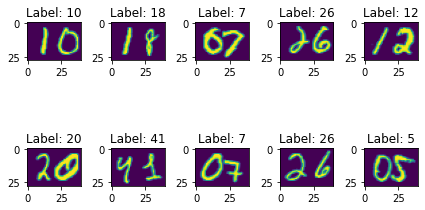

 45%|███████████████▌                   | 4452/10000 [00:00<00:00, 44519.09it/s]

mode train (45472, 28, 40) (45472,)


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 36684.50it/s]


{(28, 40)}
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
(4545, 2) (10000, 2)
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44]), array([111,  94,  93,  83,  98,  78, 103,  97, 101, 117, 127, 126, 120,
       118, 106,  98, 110,  91, 104,  98, 143, 116,  99,  94,  87, 111,
       109,  98, 116, 100, 126, 104, 111, 100,  84, 102,  90,  98,  93,
        86, 114, 102, 109,  80]))


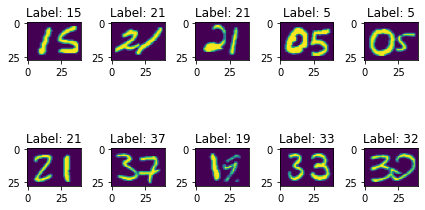

mode test (4545, 28, 40) (4545,)


In [2]:
modes = ["train", "test"]

def sort_by_name(filepath):
    return(int(Path(filepath).stem))


for mode in modes:
    file_list = sorted(glob.glob(f"./output/{mode}/2/*.png"), key = sort_by_name)
    file_list[: 100]

    # load all shapes in order to calculate average shapes for the resize
    shapes = [cv2.imread(img_path)[:, :, 0].shape for img_path in tqdm(file_list)]

    mean_h = int(np.mean([shape[0] for shape in shapes], 0))


    mean_w = int(np.mean([shape[1] for shape in shapes], 0))
    mean_w, mean_h

    #load proper img_list
    img_list = [cv2.resize(cv2.imread(img_path)[:, :, 0], (mean_w, mean_h)) for img_path in tqdm(file_list)]
    #check shapes
    print(set([img.shape for img in img_list]))

    labels = pd.read_csv(f"./output/{mode}/labels.csv", header= None, index_col= False, names = ["img_name", "label"] )
    # labels

    if mode == "train":
        #select random labels
        # unique_labels = labels.label.unique()
        # unique_labels = unique_labels[unique_labels>9]
        # print(unique_labels)
        # np.random.shuffle(unique_labels)
        # selected_label_list = unique_labels[:45]
        selected_label_list = np.arange(1, 45)
    print(selected_label_list)
    # selected_label_list = [10, 18, 61, 64, 83, 63, 46, 72, 33, 85]
    # selected_label_list, len(selected_label_list)

    selected_labels = labels[labels.label.isin(selected_label_list)]
    print(selected_labels.shape, labels.shape)

    print(np.unique(selected_labels.label, return_counts=True))

    selected_indexes = selected_labels.index.to_list()
    # selected_indexes[:10]


    selected_img_list = itemgetter(*selected_indexes)(img_list)
    selected_img_list_pathes = itemgetter(*selected_indexes)(file_list)

    # selected_img_list_pathes



    np_labels = selected_labels.label.to_numpy()
    # type(np_labels), np_labels[:10]

    np_images = np.vstack(np.expand_dims(selected_img_list, 0))
    # np_images.shape

    #a visual check
    fig, ax = plt.subplots(2, 5)
    for i in range(2):
        for j in range(5):

            index = np.random.randint(0, len(np_images))
            # print(np_labels[index])
            # print(selected_img_list_pathes[index])
            ax[i, j].imshow(np_images[index])
            ax[i, j].set_title(f'Label: {np_labels[index]}')
    plt.tight_layout()
    plt.show()
    fig.savefig(f"examples/{mode}_example.png")
    
    # np.save(f"./final_dataset/X_{mode}.npy", np_images)
    # np.save(f"./final_dataset/y_{mode}.npy", np_labels)
    
    np.savez_compressed(f"./final_dataset/X_{mode}.npz", np_images)
    np.savez_compressed(f"./final_dataset/y_{mode}.npz", np_labels)
    
    # print("mode", mode, np.load(f"./final_dataset/X_{mode}.npy").shape, np.load(f"./final_dataset/y_{mode}.npy").shape)
    print("mode", mode, np.load(f"./final_dataset/X_{mode}.npz")["arr_0"].shape, np.load(f"./final_dataset/y_{mode}.npz")["arr_0"].shape)
        

In [3]:
67 65 37 52 84 23 74 89 62 44 57 93 86 12 10 26 13 59 11 45 16 38 15 31
 92 17 77 28 68 30

SyntaxError: invalid syntax (165265106.py, line 1)

In [ ]:
 mode, np.load(f"./final_dataset/X_{mode}.npz")["arr_0"].shape